### Will they Donate?
**Anusha Kankipati, Anagha Nair**   

Loading and Configuring Dataset

In [35]:
import numpy as np


def loaddata(filename):
    # Load the data from the file, assuming no missing values and header is skipped
    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    n = len(data[0])

    # Split into features (X) and target (y)
    X = data[:, :(n-1)]  # First 4 columns
    y = data[:, -1]  # Last column
    return X, y

def normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    # Perform Z-score normalization: (X - mean) / std
    X_normalized = (X - mean) / std
    
    ones_column = np.ones((X_normalized.shape[0], 1))
    X_normalized_withbias = np.hstack((X_normalized, ones_column))
    return X_normalized_withbias


def split_data(X, y, train_size=0.8):
    # Get the total number of rows
    n = X.shape[0]
    
    # Determine the split index
    split_idx = int(train_size * n)
    np.random.shuffle(X)    
    # Split data into training and testing sets
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    
    return X_train, X_test, y_train, y_test

# Load the data
X, y = loaddata('transfusion.data')
X_norm = normalize(X)     # A key step

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X_norm, y)

# print("X_train:\n", X_train)
# print("y_train:\n", y_train)
# print("X_test:\n", X_test)
# print("y_test:\n", y_test)

#### Logistic Regression

In [36]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

def accuracyScore(predictions, labels):
    # print(labels.shape)
    n = len(labels)
    if len(predictions) != n:
        print("something's wrong, mismatched lengths")
        print(n, "is not", len(predictions))
        return
    correct = 0
    for i in range(n):
        if predictions[i] == labels[i]:
            correct = correct+1
    return correct / n



print(f"Logistic Regression Test Accuracy: {accuracyScore(y_pred, y_test)}")

Logistic Regression Test Accuracy: 0.9066666666666666


Creating and displaying confusion matrix

In [37]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

Text(0.5, 427.9555555555555, 'Predicted label')

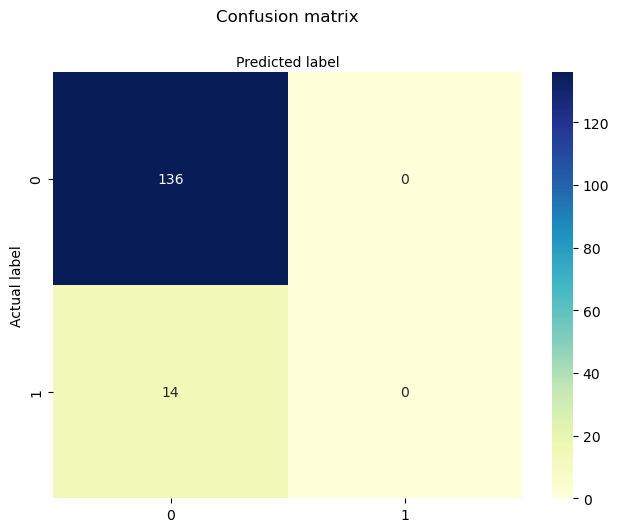

In [38]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



#### LDA and QDA
Using PCA to remove collinearity

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
def train_lda_classifier(X, y):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    return lda

def train_qda_classifier(X, y):
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X, y)
    return qda


def reduce_dimensionality(X, n_components=None):
    # Reduce the dimensionality of the data to avoid collinearity issues
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced

# Apply PCA to your training and testing data
X_train_reduced = reduce_dimensionality(X_train, n_components=2)  # 1 or 2 components maximizes test accuracy 
X_test_reduced = reduce_dimensionality(X_test, n_components=2)

lda = train_lda_classifier(X_train_reduced, y_train)
qda = train_qda_classifier(X_train_reduced, y_train)

print("LDA Training Acc", lda.score(X_train_reduced, y_train))
print("LDA Test Acc", lda.score(X_test_reduced, y_test))

print("QDA Training Acc", qda.score(X_train_reduced, y_train))
print("QDA Test Acc", qda.score(X_test_reduced, y_test))


LDA Training Acc 0.725752508361204
LDA Test Acc 0.9066666666666666
QDA Training Acc 0.725752508361204
QDA Test Acc 0.9066666666666666


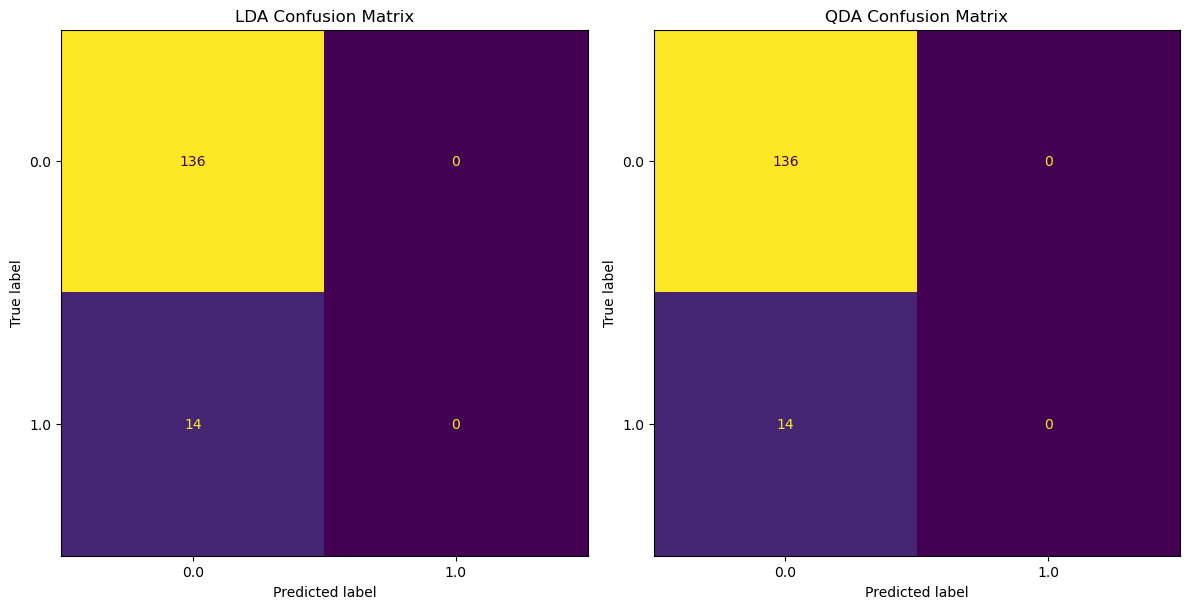

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels for the test set
lda_preds = lda.predict(X_test_reduced)
qda_preds = qda.predict(X_test_reduced)

# Generate confusion matrices
lda_cm = confusion_matrix(y_test, lda_preds)
qda_cm = confusion_matrix(y_test, qda_preds)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(lda_cm, display_labels=lda.classes_).plot(ax=axes[0], colorbar=False)
axes[0].set_title('LDA Confusion Matrix')

ConfusionMatrixDisplay(qda_cm, display_labels=qda.classes_).plot(ax=axes[1], colorbar=False)
axes[1].set_title('QDA Confusion Matrix')

plt.tight_layout()
plt.show()


Accuracy Score: 90.6% 
True Negative=136
False Negative=14

### Augmenting the Dataset
Repeating the above classifiers with the augmented dataset, containing 4 extra features. <br>
Feature 1=0.5×Recency (months)+0.3×Frequency (times)−0.2×Time (months) <br>
Feature 2=0.7×Frequency (times)−0.4×Monetary (c.c. blood)+0.2×Time (months) <br>
Feature 3=0.6×Recency (months)+0.5×Monetary (c.c. blood)−0.3×Frequency (times) <br>
Feature 4=−0.5×Recency (months)+0.4×Time (months)+0.3×Frequency (times)

In [50]:
# Load the data
X_augmented, y_augmented = loaddata('augmented_data.csv')
X_norm_augmented = normalize(X)

# Split the data into training and testing sets
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = split_data(X_norm_augmented, y_augmented)

Logistic Regression Test Accuracy: 0.9066666666666666


Text(0.5, 427.9555555555555, 'Predicted label')

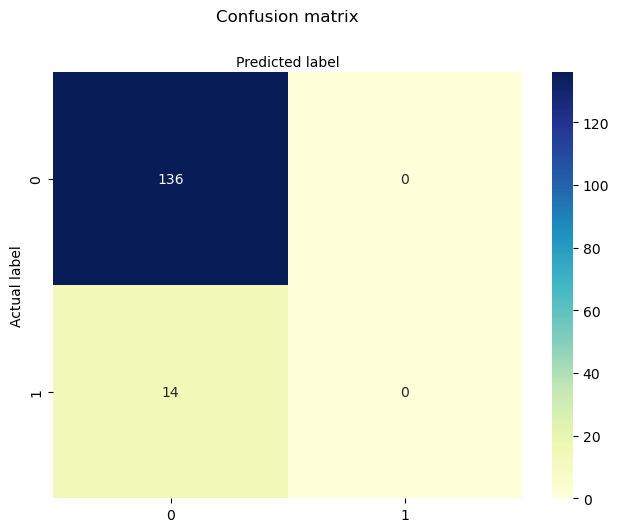

In [51]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train_augmented, y_train_augmented)

y_pred = logreg.predict(X_test_augmented)
print(f"Logistic Regression Test Accuracy: {accuracyScore(y_pred, y_test)}")

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [52]:
X_train_reduced = reduce_dimensionality(X_train_augmented, n_components=2)  # 1 or 2 components maximizes test accuracy 
X_test_reduced = reduce_dimensionality(X_test_augmented, n_components=2)

lda = train_lda_classifier(X_train_reduced, y_train_augmented)
qda = train_qda_classifier(X_train_reduced, y_train_augmented)

print("LDA Training Acc", lda.score(X_train_reduced, y_train_augmented))
print("LDA Test Acc", lda.score(X_test_reduced, y_test_augmented))

print("QDA Training Acc", qda.score(X_train_reduced, y_train_augmented))
print("QDA Test Acc", qda.score(X_test_reduced, y_test_augmented))


LDA Training Acc 0.725752508361204
LDA Test Acc 0.9066666666666666
QDA Training Acc 0.7290969899665551
QDA Test Acc 0.8933333333333333


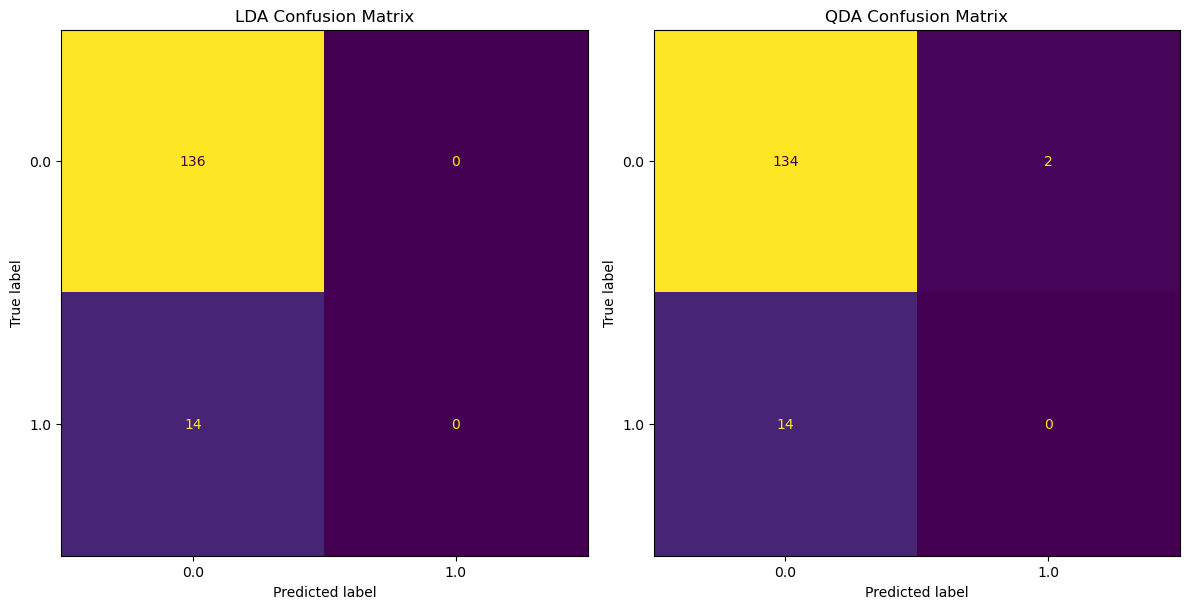

In [53]:
# Predict class labels for the test set
lda_preds = lda.predict(X_test_reduced)
qda_preds = qda.predict(X_test_reduced)

# Generate confusion matrices
lda_cm = confusion_matrix(y_test, lda_preds)
qda_cm = confusion_matrix(y_test, qda_preds)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(lda_cm, display_labels=lda.classes_).plot(ax=axes[0], colorbar=False)
axes[0].set_title('LDA Confusion Matrix')

ConfusionMatrixDisplay(qda_cm, display_labels=qda.classes_).plot(ax=axes[1], colorbar=False)
axes[1].set_title('QDA Confusion Matrix')

plt.tight_layout()
plt.show()


Accuracy Score: 90.6% 
QDA accuracy reduced to 89.3%

True Negative=136
False Negative=14



**Without Normalization**
QDA reduce to 88.6%